In [1]:
!pip install yfinance 

In [1]:
import pandas as pd 
import yfinance as yf

#### Step 1: Ensure yfinance is working 

In [2]:
def load_stock_ohlcv(
        ticker: str, 
        start_date: str,
        end_date: str,
        interval: str = "1d"
) -> pd.DataFrame:
    """
    Loads OHLCV (open, high, low, close, volume) for given ticker from start_date to end_date 
    using yfinance.
    """
    df = yf.download(ticker, start=start_date, end=end_date, interval=interval, auto_adjust=True)
    df = df.reset_index()

    # Ensure we have the basic columns 
    df = df.rename(columns={"Date": "date", "Open": "open", "High": "high",
                            "Low": "low", "Close": "close", "Volume": "volume"})
    df = df[["date", "open", "high", "low", "close", "volume"]]
    return df

ticker = "AAPL"
start_date = "2025-01-01"
end_date = "2025-10-01"
ohlcv_df = load_stock_ohlcv(ticker, start_date, end_date, interval="1d")
print(ohlcv_df.head())
print(ohlcv_df.tail())

[*********************100%***********************]  1 of 1 completed

Price        date        open        high         low       close    volume
Ticker                   AAPL        AAPL        AAPL        AAPL      AAPL
0      2025-01-02  248.049444  248.218856  240.964609  242.987427  55740700
1      2025-01-03  242.499161  243.316252  241.034359  242.499161  40244100
2      2025-01-06  243.445785  246.455106  242.339711  244.133347  45045600
3      2025-01-07  242.120491  244.681407  240.496267  241.353226  40856000
4      2025-01-08  241.064237  242.847913  239.200857  241.841476  37628900
Price        date        open        high         low       close    volume
Ticker                   AAPL        AAPL        AAPL        AAPL      AAPL
181    2025-09-24  255.220001  255.740005  251.039993  252.309998  42303700
182    2025-09-25  253.210007  257.170013  251.710007  256.869995  55202100
183    2025-09-26  254.100006  257.600006  253.779999  255.460007  46076300
184    2025-09-29  254.559998  255.000000  253.009995  254.429993  40127700
185    2025-

#### Step 2: Collect data

In [ ]:
import pandas as pd 
import yfinance as yf 
from typing import List 

def download_multiple_tickers(
        tickers: List[str],
        start_date: str, 
        end_date: str, 
        interval: str = "1d"
) -> pd.DataFrame:
    """
    Downloads adjusted OHLCV data for multiple tickers using yfinance and 
    returns a tidy long-format dataframe.
    """
    
    # Download all tickers together (yfinance will make multi-index columns)
    df = yf.download(tickers, start=start_date, end=end_date, interval=interval, auto_adjust=True, progress=False)

    # Flatten the multi-index columns (e.g., ('Close', 'AAPL') -> 'AAPL_Close')
    df.columns = [f"{ticker}_{col}" for col, ticker in df.columns]
    df = df.reset_index() # make 'Date' a column 

    # Melt into tidy format: one row per date-ticker 
    tidy_records = []
    for symbol in tickers:
        symbol_df = df[[
            "Date",
            f"{symbol}_Open", 
            f"{symbol}_High", 
            f"{symbol}_Low",
            f"{symbol}_Close", 
            f"{symbol}_Volume"
        ]].copy() # Copy ensure we make a superate df. 
        symbol_df.columns = ["date", "open", "high", "low", "close", "volume"] # renames
        symbol_df['ticker'] = symbol 
        tidy_records.append(symbol_df)
    
    tidy_df = pd.concat(tidy_records, ignore_index = True)
    tidy_df = tidy_df.sort_values(['ticker', 'date']).reset_index(drop=True) # sort by name and list, and resets the row numbers cleanly.
    return tidy_df 

tickers = ["META", "AAPL", "MSFT", "GOOGL"]
start_date = "2015-01-01"
end_date = "2025-10-01"

market_df = download_multiple_tickers(tickers, start_date, end_date) 
print(market_df.head(20))
print(market_df.tail(20))
print(market_df.ticker.value_counts())




         date       open       high        low      close     volume ticker
0  2015-01-02  24.718169  24.729265  23.821666  24.261042  212818400   AAPL
1  2015-01-05  24.030261  24.110148  23.391171  23.577572  257142000   AAPL
2  2015-01-06  23.641928  23.839424  23.218085  23.579794  263188400   AAPL
3  2015-01-07  23.788387  24.010294  23.677434  23.910437  160423600   AAPL
4  2015-01-08  24.238861  24.886828  24.121249  24.829132  237458000   AAPL
5  2015-01-09  25.002216  25.130922  24.456326  24.855759  214798000   AAPL
6  2015-01-12  24.986671  24.993328  24.143427  24.243284  198603200   AAPL
7  2015-01-13  24.727045  25.031057  24.167841  24.458538  268367600   AAPL
8  2015-01-14  24.196694  24.518457  24.076864  24.365343  195826400   AAPL
9  2015-01-15  24.409719  24.423032  23.668552  23.704056  240056000   AAPL
10 2015-01-16  23.750661  23.872711  23.344572  23.519878  314053200   AAPL
11 2015-01-20  23.930408  24.181163  23.633054  24.125687  199599600   AAPL
12 2015-01-2

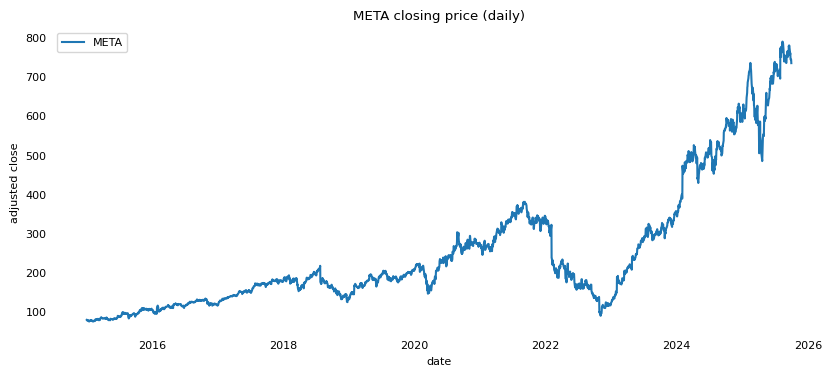

In [40]:
import matplotlib.pyplot as plt

example_ticker = "META"
meta_df = market_df[market_df["ticker"] == example_ticker]

plt.figure(figsize=(10,4))
plt.plot(meta_df["date"], meta_df["close"], label=example_ticker)
plt.title(f"{example_ticker} closing price (daily)")
plt.xlabel("date")
plt.ylabel("adjusted close")
plt.legend()
plt.show()


#### Step 3: Create charts for CNN

We will convert our historical stock data (OHLCV) into candlestick chart images and compute their future 5-day log returns.

For each ticker, we take a fixed lookback window of the last 120 trading days (~6 months), which will be used as the context the model sees. We slide this window forward day by day, producing thousands of overlapping samples.

For each window, we took 5 trading days into the future and compute the logarithmic return: 

log-return = ln(Pt+5 / Pt)

Where 
- Pt = closing price on the last day of the 120-day window. 
- Pt+5 = closing price fice days later

This value then becomes the **training target** for the CNN-VIT model.

Log-returns are for normalizing values. 


In [6]:
pip install mplfinance

Note: you may need to restart the kernel to use updated packages.


In [43]:
import io
import math
import torch
from torch.utils.data import Dataset
import numpy as np
import matplotlib.pyplot as plt
import mplfinance as mpf
import pandas as pd
from typing import List


class StockCandleChartDataset1(Dataset):
    def __init__(
        self,
        df: pd.DataFrame,
        tickers: List[str],
        lookback_window: int,
        forecast_horizon: int,
        image_height: int,
        image_width: int,
        include_volume: bool = True,
        dpi: int = 100
    ):
        self.dataframe_all = df.copy()
        self.ticker_list = tickers
        self.lookback_window_days = lookback_window
        self.forecast_horizon_days = forecast_horizon
        self.image_height_px = image_height
        self.image_width_px = image_width
        self.include_volume = include_volume
        self.render_dpi = dpi

        # Style
        self.market_colors = mpf.make_marketcolors(
            up="#26a69a",
            down="#ef5350",
            edge="inherit",
            wick="inherit",
            volume="#1f77b4",
            alpha=1.0
        )
        self.chart_style = mpf.make_mpf_style(
            marketcolors=self.market_colors,
            gridstyle="",
            y_on_right=False,
            rc={
                "font.size": 8,
                "axes.linewidth": 0,
                "xtick.major.size": 0,
                "ytick.major.size": 0,
            }
        )

        self.sample_index = []
        for ticker_symbol in self.ticker_list:
            ticker_frame = self.dataframe_all[self.dataframe_all["ticker"] == ticker_symbol].reset_index(drop=True)
            max_end_index = len(ticker_frame) - self.forecast_horizon_days - 1
            for end_index in range(self.lookback_window_days, max_end_index):
                self.sample_index.append((ticker_symbol, end_index))

        print(f"Created {len(self.sample_index)} samples across {len(self.ticker_list)} tickers")

    def _render_candlestick(self, ohlcv_window: pd.DataFrame) -> np.ndarray:
        fig_width_in = self.image_width_px / self.render_dpi
        fig_height_in = self.image_height_px / self.render_dpi

        fig, axes = mpf.plot(
            ohlcv_window,
            type="candle",
            volume=self.include_volume,
            style=self.chart_style,
            figsize=(fig_width_in, fig_height_in),
            returnfig=True,
            tight_layout=True,
            scale_padding={"left": 0.02, "right": 0.02, "top": 0.02, "bottom": 0.08},
        )

        for axis in axes:
            axis.set_axis_off()
            axis.margins(0)

        fig.set_dpi(self.render_dpi)
        fig.set_size_inches(fig_width_in, fig_height_in, forward=True)

        buffer = io.BytesIO()
        fig.savefig(
            buffer,
            format="png",
            dpi=self.render_dpi,
            bbox_inches="tight",
            pad_inches=0,
            facecolor="white",
            edgecolor="none",
        )
        plt.close(fig)
        buffer.seek(0)

        image_rgb = plt.imread(buffer, format="png")[..., :3]
        buffer.close()
        image_chw = np.transpose(image_rgb.astype(np.float32), (2, 0, 1))
        return image_chw

    def __len__(self):
        return len(self.sample_index)

    def __getitem__(self, idx: int):
        ticker_symbol, end_index = self.sample_index[idx]
        ticker_frame = self.dataframe_all[self.dataframe_all["ticker"] == ticker_symbol].reset_index(drop=True)
        ohlcv_frame = ticker_frame.loc[:, ["date", "open", "high", "low", "close", "volume"]].copy()
        ohlcv_frame["date"] = pd.to_datetime(ohlcv_frame["date"])
        ohlcv_frame = ohlcv_frame.set_index("date")

        window_frame = ohlcv_frame.iloc[end_index - self.lookback_window_days : end_index]
        image_tensor = torch.from_numpy(self._render_candlestick(window_frame))

        future_close = float(ohlcv_frame.iloc[end_index + self.forecast_horizon_days]["close"])
        current_close = float(ohlcv_frame.iloc[end_index - 1]["close"])
        target_log_return = math.log(future_close / current_close)
        target_tensor = torch.tensor(target_log_return, dtype=torch.float32)

        return image_tensor, target_tensor


In [5]:
import os
import io
import gc
import math
import torch
import numpy as np
import pandas as pd
import matplotlib
matplotlib.use("Agg")  # headless backend for safe rendering
import matplotlib.pyplot as plt
import mplfinance as mpf
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
from typing import List

class StockCandleChartDataset(Dataset):
    def __init__(
        self,
        df: pd.DataFrame,
        tickers: List[str],
        lookback_window: int,
        forecast_horizon: int,
        image_height: int = 400,
        image_width: int = 600,
        dpi: int = 150,
        include_volume: bool = True,
        cache_dir: str = "chart_cache"
    ):
        self.dataframe_all = df.copy()
        self.ticker_list = tickers
        self.lookback_window_days = lookback_window
        self.forecast_horizon_days = forecast_horizon
        self.image_height_px = image_height
        self.image_width_px = image_width
        self.include_volume = include_volume
        self.render_dpi = dpi
        self.cache_dir = Path(cache_dir)
        self.cache_dir.mkdir(parents=True, exist_ok=True)

        self.market_colors = mpf.make_marketcolors(
            up="#26a69a",
            down="#ef5350",
            edge="inherit",
            wick="inherit",
            volume="#1f77b4",
            alpha=1.0
        )
        self.chart_style = mpf.make_mpf_style(
            marketcolors=self.market_colors,
            gridstyle="",
            y_on_right=False,
            rc={
                "font.size": 8,
                "axes.linewidth": 0,
                "xtick.major.size": 0,
                "ytick.major.size": 0,
            }
        )

        self.sample_index = []
        for ticker_symbol in self.ticker_list:
            ticker_frame = self.dataframe_all[self.dataframe_all["ticker"] == ticker_symbol].reset_index(drop=True)
            max_end_index = len(ticker_frame) - self.forecast_horizon_days - 1
            for end_index in range(self.lookback_window_days, max_end_index):
                self.sample_index.append((ticker_symbol, end_index))

        print(f"Prepared {len(self.sample_index)} samples from {len(self.ticker_list)} tickers")

    def _render_candlestick(self, ohlcv_window: pd.DataFrame) -> np.ndarray:
        fig_width_in = self.image_width_px / self.render_dpi
        fig_height_in = self.image_height_px / self.render_dpi

        fig, axes = mpf.plot(
            ohlcv_window,
            type="candle",
            volume=self.include_volume,
            style=self.chart_style,
            figsize=(fig_width_in, fig_height_in),
            returnfig=True,
            tight_layout=True,
            scale_padding={"left": 0.02, "right": 0.02, "top": 0.02, "bottom": 0.08},
        )

        for axis in axes:
            axis.set_axis_off()
            axis.margins(0)

        buffer = io.BytesIO()
        fig.savefig(
            buffer,
            format="png",
            dpi=self.render_dpi,
            bbox_inches="tight",
            pad_inches=0,
            facecolor="white",
            edgecolor="none",
        )
        plt.close(fig)
        buffer.seek(0)

        image_rgb = plt.imread(buffer, format="png")[..., :3]
        buffer.close()
        plt.close("all")
        gc.collect()

        image_chw = np.transpose(image_rgb.astype(np.float32), (2, 0, 1))
        return image_chw

    def _render_and_save_chart(self, idx: int):
        ticker_symbol, end_index = self.sample_index[idx]
        cache_file = self.cache_dir / f"{ticker_symbol}_{end_index}.npz"
        if cache_file.exists():
            return

        ticker_frame = self.dataframe_all[self.dataframe_all["ticker"] == ticker_symbol].reset_index(drop=True)
        ohlcv_frame = ticker_frame.loc[:, ["date", "open", "high", "low", "close", "volume"]].copy()
        ohlcv_frame["date"] = pd.to_datetime(ohlcv_frame["date"])
        ohlcv_frame = ohlcv_frame.set_index("date")

        window_frame = ohlcv_frame.iloc[end_index - self.lookback_window_days: end_index]
        image_chw = self._render_candlestick(window_frame)

        future_close = float(ohlcv_frame.iloc[end_index + self.forecast_horizon_days]["close"])
        current_close = float(ohlcv_frame.iloc[end_index - 1]["close"])
        target_log_return = math.log(future_close / current_close)

        np.savez_compressed(cache_file, img=image_chw, target=target_log_return)

    def pre_render_all(self):
        print("\nPre-rendering candlestick charts (one-time build)...")
        for i in range(len(self.sample_index)):
            if i % 200 == 0:
                print(f"Rendering {i}/{len(self.sample_index)}")
            self._render_and_save_chart(i)
        print("All charts cached.")

    def __len__(self):
        return len(self.sample_index)

    def __getitem__(self, idx: int):
        ticker_symbol, end_index = self.sample_index[idx]
        cache_file = self.cache_dir / f"{ticker_symbol}_{end_index}.npz"
        if not cache_file.exists():
            raise FileNotFoundError(f"Cached chart missing: {cache_file}. Run dataset.pre_render_all() first.")
        cached = np.load(cache_file)
        image_tensor = torch.from_numpy(cached["img"])
        target_tensor = torch.tensor(float(cached["target"]), dtype=torch.float32)
        return image_tensor, target_tensor



Created 10304 samples across 4 tickers
Target log-return:  0.046112507581710815


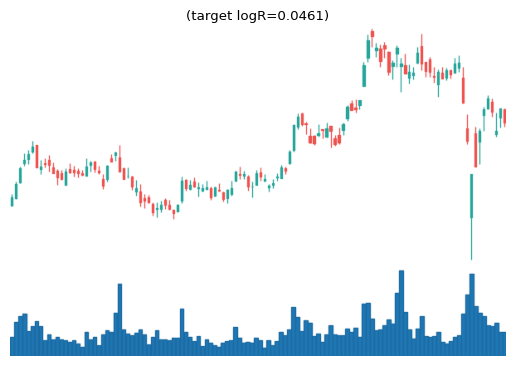

In [46]:
chart_dataset = StockCandleChartDataset1(
    df=market_df,
    tickers=tickers,
    lookback_window=120, # what about 60 (quarterly)
    forecast_horizon=5,
    image_height=400,
    image_width=600,
    dpi=150  # Increase for sharper images
)

image, target = chart_dataset[50]
print("Target log-return: ", target.item())
plt.imshow(np.transpose(image.numpy(), (1, 2, 0)))
plt.title(f"(target logR={target.item():.4f})")
plt.axis("off")
plt.show()

- The green and red bars correspond to daily price moves. 
- The lower bars represent traded volume. 
- The model's target (logR=0.0461) indicates that, over the next 5 trading days following this window, the stock increased by about 4.61% in log-return terms. 

In [7]:
chart_dataset = StockCandleChartDataset(
    df=market_df,
    tickers=tickers,
    lookback_window=120,
    forecast_horizon=5,
    image_height=400,
    image_width=600,
    dpi=150
)

# One-time pre-render step (slow but permanent)
chart_dataset.pre_render_all()
image, target = chart_dataset[50]
print("Target log-return:", target.item())

plt.imshow(np.transpose(image.numpy(), (1, 2, 0)))
plt.title(f"(target logR={target.item():.4f})")
plt.axis("off")
plt.show()


Prepared 10304 samples from 4 tickers

Pre-rendering candlestick charts (one-time build)...
Rendering 0/10304
Rendering 200/10304
Rendering 400/10304
Rendering 600/10304
Rendering 800/10304
Rendering 1000/10304
Rendering 1200/10304
Rendering 1400/10304
Rendering 1600/10304
Rendering 1800/10304
Rendering 2000/10304
Rendering 2200/10304
Rendering 2400/10304
Rendering 2600/10304
Rendering 2800/10304
Rendering 3000/10304
Rendering 3200/10304
Rendering 3400/10304
Rendering 3600/10304
Rendering 3800/10304
Rendering 4000/10304
Rendering 4200/10304
Rendering 4400/10304
Rendering 4600/10304
Rendering 4800/10304
Rendering 5000/10304
Rendering 5200/10304
Rendering 5400/10304
Rendering 5600/10304
Rendering 5800/10304
Rendering 6000/10304
Rendering 6200/10304
Rendering 6400/10304
Rendering 6600/10304
Rendering 6800/10304
Rendering 7000/10304
Rendering 7200/10304
Rendering 7400/10304
Rendering 7600/10304
Rendering 7800/10304
Rendering 8000/10304
Rendering 8200/10304
Rendering 8400/10304
Rendering 86

C:\Users\sekai\AppData\Local\Temp\ipykernel_21860\4098711627.py:19: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


In [9]:
print(image.shape)


torch.Size([3, 396, 598])


In [10]:
print(target)

tensor(0.0461)


#### Step 4: Library imports and set seed

In [11]:
import numpy as np 
import torch 
import torch.nn as nn 
import torch.nn.functional as F 
import torch.optim as optim 
from torchvision import transforms, datasets 
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
import time 
from datetime import datetime

def present_time():
        return datetime.now().strftime('%Y%m%d_%H%M%S')


In [12]:
import random

def set_seed(seed: int = 42) -> None:
    """Seed Python, NumPy, and PyTorch (CPU & all GPUs) and
    make cuDNN run in deterministic mode."""

    # Python and NumPy
    random.seed(seed)
    np.random.seed(seed)

    # PyTorch (CPU & GPU)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # cuDNN: force repeatable convolutions
    
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [13]:
SEED = 42
set_seed(SEED)
print(f"Global seed set to {SEED} -- main process is now detemrinistc.")

Global seed set to 42 -- main process is now detemrinistc.


#### Step 5: The data pipeline and splitting the dataset

In [14]:
dataset_length = len(chart_dataset)

train_size = int(0.8 * dataset_length)
valid_size = dataset_length - train_size
test_size = dataset_length - train_size - valid_size

train_dataset, valid_dataset, test_dataset = random_split(chart_dataset, [train_size, valid_size, test_size])


In [15]:
dataset_length = len(chart_dataset)

train_size = int(0.8 * dataset_length)
valid_size = int(0.1 * dataset_length)
test_size = dataset_length - train_size - valid_size

# Ensure sequential split for time series data
train_dataset = torch.utils.data.Subset(chart_dataset, range(0, train_size))
valid_dataset = torch.utils.data.Subset(chart_dataset, range(train_size, train_size + valid_size))
test_dataset = torch.utils.data.Subset(chart_dataset, range(train_size + valid_size, dataset_length))


In [18]:
def build_split_indices(dataset: StockCandleChartDataset, train_ratio=0.8, val_ratio=0.1):
    ticker_groups = {}
    for i, (ticker_symbol, end_index) in enumerate(dataset.sample_index):
        ticker_groups.setdefault(ticker_symbol, []).append(i)
    
    train_idx, val_idx, test_idx = [], [], []
    for ticker, indices in ticker_groups.items():
        n = len(indices)
        train_end = int(train_ratio * n)
        val_end = train_end + int(val_ratio * n)
        train_idx.extend(indices[:train_end])
        val_idx.extend(indices[train_end:val_end])
        test_idx.extend(indices[val_end:])
    
    return train_idx, val_idx, test_idx

train_idx, val_idx, test_idx = build_split_indices(chart_dataset)

train_dataset = torch.utils.data.Subset(chart_dataset, train_idx)
valid_dataset = torch.utils.data.Subset(chart_dataset, val_idx)
test_dataset  = torch.utils.data.Subset(chart_dataset, test_idx)


In [19]:
print(train_dataset[0][1], valid_dataset[0][1])


tensor(-0.0178) tensor(0.0094)


In [20]:
batch_size = 32
num_workers = 0

In [21]:
train_loader = DataLoader(
    train_dataset, 
    batch_size = batch_size, 
    shuffle = True,
    num_workers = num_workers,
    pin_memory = True
)

In [22]:
valid_loader = DataLoader(
    valid_dataset,
    batch_size = batch_size,
    shuffle=False,
    num_workers = num_workers,
    pin_memory = True
)

In [23]:
test_loader = DataLoader(
    test_dataset, 
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory = True
)

#### Step 6: Define the CNN Model

In [24]:
class ConvNet(nn.Module):
    def __init__(self, in_channels: int = 3, feature_channels: int = 64):
        super().__init__()
        self.features = nn.Sequential(
            # Conv Block 1
            nn.Conv2d(in_channels, feature_channels // 2, 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(feature_channels // 2),

            # Conv Block 2 - 5
            nn.Conv2d(feature_channels // 2, feature_channels, 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(feature_channels),
            nn.Conv2d(feature_channels, feature_channels * 2, 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(feature_channels * 2),
            nn.Conv2d(feature_channels * 2, feature_channels * 4, 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(feature_channels * 4),
            nn.Conv2d(feature_channels * 4, feature_channels * 8, 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(feature_channels * 8),
            nn.Conv2d(feature_channels * 8, feature_channels * 16, 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(feature_channels * 16),
        )

    def forward_features(self, x: torch.Tensor) -> torch.Tensor:
        return self.features(x)

#### Step 7: PatchEmbed

In [25]:
class PatchEmbed(nn.Module):
    def __init__(self, input_channel = 1024, embed_dim = 768):
        super().__init__()
        self.proj = nn.Conv2d(input_channel, embed_dim, kernel_size=1) # 1 x 1 conv

    def forward(self, x):
        x = self.proj(x).flatten(2).transpose(1, 2) # B, L, D
        return x

#### Step 8: Multi-head self-attention (MHSA) module

In [26]:
class MHSA(nn.Module):
    def __init__(self, dim, heads=8, dropout=0.):
        super().__init__()
        self.heads = heads 
        self.scale = (dim // heads) ** -0.5
        self.qkv = nn.Linear(dim, dim * 3)
        self.attn_drop = nn.Dropout(dropout)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(dropout)

    def forward(self, x):
        B, N, D = x.shape
        q, k, v = self.qkv(x).chunk(3, dim=-1)
        q = q.reshape(B, N, self.heads, -1).transpose(1, 2) # B, heads, N, d
        k = k.reshape(B, N, self.heads, -1).transpose(1, 2)
        k = k.reshape(B, N, self.heads, -1).transpose(1, 2)
        v = v.reshape(B, N, self.heads, -1).transpose(1, 2)
        attn = torch.matmul(q, k.transpose(-2, -1) * self.scale)
        attn = self.attn_drop(attn.softmax(dim=-1))
        x = torch.matmul(attn, v).transpose(1, 2).reshape(B, N, D)
        return self.proj_drop(self.proj(x))

#### Step 9: TransformerBlock

In [27]:
class TransformerBlcok(nn.Module):
    def __init__(self, dim, heads, mlp_ratio = 4, dropout = 0.):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = MHSA(dim, heads, dropout)
        self.norm2 = nn.LayerNorm(dim)
        self.mlp = nn.Sequential(
            nn.Linear(dim, int(dim * mlp_ratio)),
            nn.GELU(),
            nn.Dropout(),
            nn.Linear(int(dim * mlp_ratio), dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

#### Step 10: ViT model

In [28]:
class ViT(nn.Module):
    def __init__(self, in_ch = 1024, embed_dim = 768, depth = 6, heads = 8, mlp_ratio = 4., dropout = 0.1, max_tokens = 100):
        super().__init__()
        self.patch = PatchEmbed(in_ch, embed_dim)
        self.cls = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos = nn.Parameter(torch.randn(1, max_tokens, embed_dim))
        self.blocks = nn.ModuleList([
            TransformerBlcok(embed_dim, heads, mlp_ratio, dropout)
            for _ in range(depth)
        ])
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, 1) # Single output for regression

    def forward(self, x):
        x = self.patch(x)
        B, L, _ = x.shape
        cls = self.cls.expand(B, -1, -1)
        x = torch.cat((cls, x), 1)
        x = x + self.pos[:, :L + 1]
        for blk in self.blocks:
            x = blk(x)
        return self.head(self.norm(x)[:, 0])

#### Step 11: CNN-ViT hybrid model

In [29]:
class CNN_ViT_Hybrid(nn.Module):
    def __init__(self, in_channels = 3, embed_dim = 768, depth = 6, heads = 8):
        super().__init__()
        self.cnn = ConvNet(in_channels = in_channels)
        self.vit = ViT(
            embed_dim = embed_dim,
            depth = depth,
            heads = heads
        )
    
    def forward(self, x):
        return self.vit(self.cnn.forward_features(x))

#### Step 12: Model Training

In [30]:
def train(model, loader, optimizer, criterion, device):
    model.train()
    loss_sum = 0
    # correct = 0
    for batch_idx, (x, y) in enumerate(tqdm(loader, desc="Training ")):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x).squeeze()
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        loss_sum += loss.item() * x.size(0)
        # correct += (out.argmax(1) == y).sum().item()
    return loss_sum / len(loader.dataset)
# , correct / len(loader.dataset)


#### Step 13: Model evaluation

In [31]:
def evaluate(model, loader, criterion, device):
    with torch.no_grad():
        model.eval()
        loss_sum  = 0
        for batch_idx, (x, y) in enumerate(tqdm(loader, desc="Validation")):
            x, y = x.to(device), y.to(device)
            out = model(x).squeeze()
            loss = criterion(out, y)
            loss_sum += loss.item() * x.size(0)
    return loss_sum / len(loader.dataset)


#### Step 14: Test

In [32]:
def test(model, loader, criterion, device):
    with torch.no_grad():
        model.eval()
        loss_sum = 0
        for batch_idx, (x, y) in enumerate(tqdm(loader, desc="Testing   ")):
            x, y = x.to(device), y.to(device)
            out = model(x).squeeze()
            loss = criterion(out, y)
            loss_sum += loss.item() * x.size(0)
    return loss_sum / len(loader.dataset)

#### Step 14: Training loop

In [33]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Training the model on {device}")

lr = 0.0003
epochs = 15 
attn_heads = 12
depth = 18
embed_dim = 768

print(f"epochs:{epochs} | batch:{batch_size} | attn_heads:{attn_heads} | depth:{depth} | embed_dim:{embed_dim}")

model_dict_name = f"model.pth"

model = CNN_ViT_Hybrid(
    in_channels=3,
    heads=attn_heads,
    depth=depth,
    embed_dim=embed_dim
).to(device)

criterion = nn.MSELoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

best_loss = float('inf')
tr_loss_all = []
te_loss_all = []
# tr_acc_all = []
# te_acc_all = []

training_time = []

for epoch in range(1, epochs+1):
    start_time = time.time()
    print(f"\nEpoch {epoch: 02d}/{epochs:02d} started at {present_time()}")
    tr_loss = train(model, train_loader, optimizer, criterion, device)
    te_loss = evaluate(model, valid_loader, criterion, device)
    ##
    print(f"Epoch {epoch:02d} | "
          f"train loss {tr_loss:.4f} |"
          f"val loss {te_loss:.4f} |"
          f" in  {time.time()-start_time:.02f}s"
        )
    tr_loss_all.append(tr_loss)
    te_loss_all.append(te_loss)
    # tr_acc_all.append(tr_acc)
    # te_acc_all.append(te_acc)
    training_time.append(time.time() - start_time)

    # save the best model 
    avg_te_loss = te_loss
    if avg_te_loss < best_loss:
        print(f"Current loss ({avg_te_loss: .04f}) lower than previous best loss ({best_loss:.04f}), Saving current model state")
        best_loss = avg_te_loss
        torch.save(model.state_dict(), model_dict_name)

print(f"epochs:{epochs} | batch:{batch_size} | attn_heads:{attn_heads} | depth:{depth} | embed_dim:{embed_dim}")


print(f"\nTraining completed!")

# Test on test set
print(f"\n{'='*60}")
print("Testing on held-out test set...")
print(f"{'='*60}")

# Load best model
model.load_state_dict(torch.load(model_dict_name))

# Test
test_loss = test(model, test_loader, criterion, device)
print(f"\nTest Loss: {test_loss:.6f}")


Training the model on cuda
epochs:15 | batch:32 | attn_heads:12 | depth:18 | embed_dim:768

Epoch  1/15 started at 20251031_232945


Validation: 100%|██████████| 33/33 [00:19<00:00,  1.72it/s]


Epoch 01 | train loss 0.6105 |val loss 0.0016 | in  249.25s
Current loss ( 0.0016) lower than previous best loss (inf), Saving current model state

Epoch  2/15 started at 20251031_233354


Validation: 100%|██████████| 33/33 [00:08<00:00,  3.72it/s]


Epoch 02 | train loss 0.0031 |val loss 0.0022 | in  152.33s

Epoch  3/15 started at 20251031_233627


Validation: 100%|██████████| 33/33 [00:08<00:00,  3.85it/s]


Epoch 03 | train loss 0.0031 |val loss 0.0016 | in  149.63s

Epoch  4/15 started at 20251031_233856


Validation: 100%|██████████| 33/33 [00:08<00:00,  3.67it/s]


Epoch 04 | train loss 0.0031 |val loss 0.0020 | in  151.50s

Epoch  5/15 started at 20251031_234128


Validation: 100%|██████████| 33/33 [00:08<00:00,  3.67it/s]


Epoch 05 | train loss 0.0030 |val loss 0.0017 | in  152.08s

Epoch  6/15 started at 20251031_234400


Validation: 100%|██████████| 33/33 [00:09<00:00,  3.62it/s]


Epoch 06 | train loss 0.0029 |val loss 0.0017 | in  154.43s

Epoch  7/15 started at 20251031_234634


Validation: 100%|██████████| 33/33 [00:09<00:00,  3.52it/s]


Epoch 07 | train loss 0.0029 |val loss 0.0020 | in  154.47s

Epoch  8/15 started at 20251031_234909


Validation: 100%|██████████| 33/33 [00:08<00:00,  3.79it/s]


Epoch 08 | train loss 0.0029 |val loss 0.0018 | in  153.15s

Epoch  9/15 started at 20251031_235142


Validation: 100%|██████████| 33/33 [00:08<00:00,  3.83it/s]


Epoch 09 | train loss 0.0030 |val loss 0.0020 | in  147.21s

Epoch  10/15 started at 20251031_235409


Validation: 100%|██████████| 33/33 [00:08<00:00,  3.73it/s]


Epoch 10 | train loss 0.0031 |val loss 0.0020 | in  147.92s

Epoch  11/15 started at 20251031_235637


Validation: 100%|██████████| 33/33 [00:08<00:00,  3.83it/s]


Epoch 11 | train loss 0.0028 |val loss 0.0030 | in  149.28s

Epoch  12/15 started at 20251031_235906


Validation: 100%|██████████| 33/33 [00:08<00:00,  3.73it/s]


Epoch 12 | train loss 0.0026 |val loss 0.0063 | in  147.73s

Epoch  13/15 started at 20251101_000134


Validation: 100%|██████████| 33/33 [00:08<00:00,  3.71it/s]


Epoch 13 | train loss 0.0027 |val loss 0.0021 | in  148.66s

Epoch  14/15 started at 20251101_000403


Validation: 100%|██████████| 33/33 [00:08<00:00,  3.86it/s]


Epoch 14 | train loss 0.0026 |val loss 0.0020 | in  146.62s

Epoch  15/15 started at 20251101_000629


Validation: 100%|██████████| 33/33 [00:08<00:00,  3.86it/s]


Epoch 15 | train loss 0.0026 |val loss 0.0040 | in  146.46s
epochs:15 | batch:32 | attn_heads:12 | depth:18 | embed_dim:768

Training completed!

Testing on held-out test set...


Testing   : 100%|██████████| 33/33 [00:18<00:00,  1.83it/s]


Test Loss: 0.002093


test loss = 
sqrt(0.002093)​≈0.0457
e0.0457−1≈4.68%

In [34]:
import torch
import numpy as np
from tqdm import tqdm

model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for images, targets in tqdm(test_loader, desc="Collecting predictions"):
        images = images.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True)

        preds = model(images).squeeze()   # shape [B]
        all_preds.append(preds.cpu().numpy())
        all_targets.append(targets.cpu().numpy())

# Flatten
y_pred = np.concatenate(all_preds)
y_true = np.concatenate(all_targets)


In [35]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"MSE: {mse:.6f}")
print(f"MAE: {mae:.6f}")
print(f"R²:  {r2:.4f}")


MSE: 0.002093
MAE: 0.034754
R²:  -0.0064


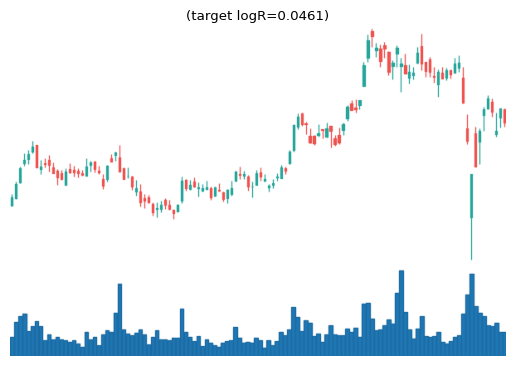

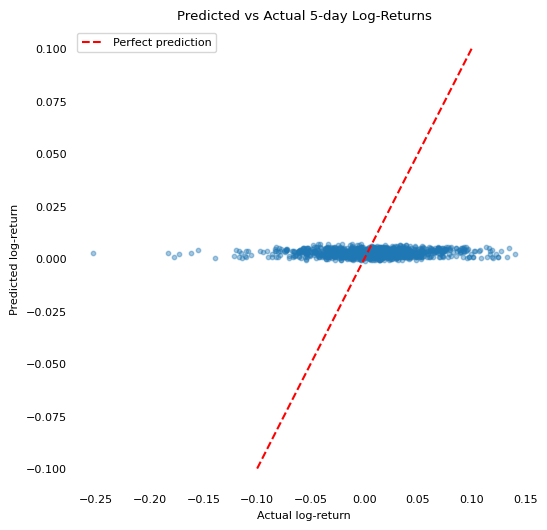

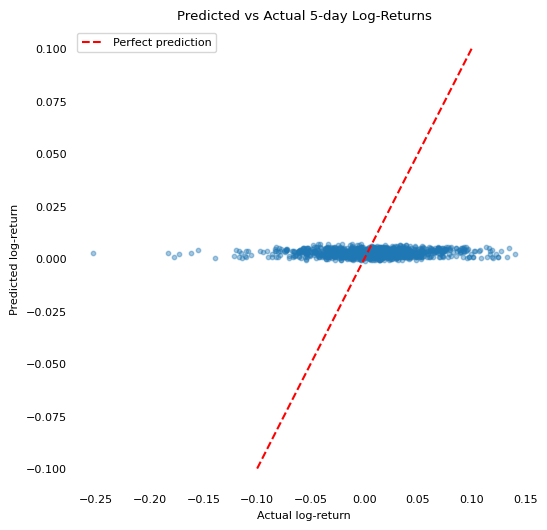

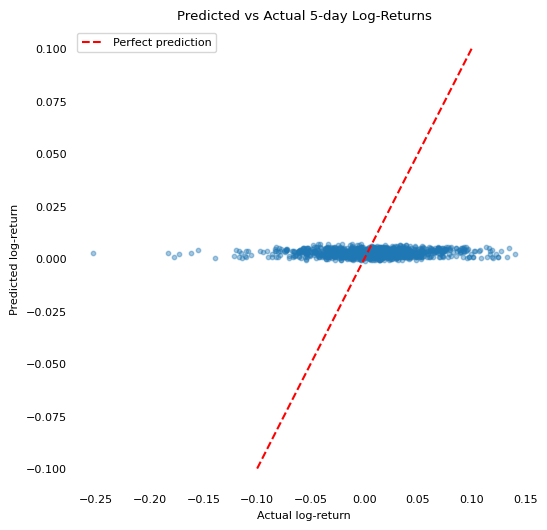

In [38]:
import matplotlib
matplotlib.use("module://matplotlib_inline.backend_inline")  # for Jupyter inline plots

import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(y_true, y_pred, alpha=0.4, s=10)
plt.xlabel("Actual log-return")
plt.ylabel("Predicted log-return")
plt.title("Predicted vs Actual 5-day Log-Returns")
plt.plot([-0.1, 0.1], [-0.1, 0.1], 'r--', label='Perfect prediction')
plt.legend()
plt.grid(True)
plt.show()


#### Step 7: Connect ConvNet with ViT & probablistic head

The code below is a product of ChatGPT.

In [32]:
class ViTProbHead(nn.Module):
    def __init__(
            self,
            cnn_backbone: nn.Module,
            transformer_dim: int = 128,
            transformer_heads: int = 4,
            transformer_layers: int = 3,
            transformer_mlp_ratio: float = 2.0, 
            transformer_dropout: float = 0.1,
    ):
        super().__init__()
        self.backbone = cnn_backbone

        # Forward once to find flattened shape dynamically 
        with torch.no_grad():
            dummy = torch.zeros(1, 3, 396, 598)
            feature_map = self.backbone.forward_features(dummy)
            _, c ,h, w = feature_map.shape 
            self.num_tokens = h * w
            self.token_dim = c 

        self.token_proj = nn.Linear(self.token_dim, transformer_dim)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, transformer_dim))
        self.pos_embed = nn.Parameter(torch.randn(1, self.num_tokens + 1, transformer_dim) * 0.02)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model = transformer_dim,
            nhead = transformer_heads,
            dim_feedforward = int(transformer_dim * transformer_mlp_ratio),
            dropout = transformer_dropout,
            batch_first = True,
            norm_first = True,
            activation = "gelu"
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=transformer_layers)

        self.head = nn.Sequential(
            nn.LayerNorm(transformer_dim),
            nn.Linear(transformer_dim, 2) # mean (mu) and log(sigma)
        )

    def forward(self, x: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        feature_map = self.backbone.forward_features(x)
        b, c, h, w = feature_map.shape 

        tokens = feature_map.permute(0, 2, 3, 1).reshape(b, h * w, c)
        tokens = self.token_proj(tokens)

        cls = self.cls_token.expand(b, -1, -1)
        tokens =  torch.cat([cls, tokens], dim=1)
        tokens = tokens + self.pos_embed[:, :tokens.size(1), :]

        encoded = self.transformer(tokens)
        cls_emb = encoded[:, 0, :]
        out = self.head(cls_emb)

        mu = out[:, 0]
        log_sigma = out[:, 1]
        
        return mu, log_sigma



In [33]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [34]:
cnn_backbone = ConvNet(in_channels = 3, feature_channels = 64)
model = ViTProbHead(cnn_backbone).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr = 3e-4, weight_decay=1e-4)


c:\Users\sekai\.conda\envs\AI\Lib\site-packages\torch\nn\modules\transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


#### Stpe 8: Define the Gaussian Negative Log-Likelihood Loss

In [35]:
def gaussian_nll_loss(target: torch.Tensor, mu: torch.Tensor, log_sigma: torch.Tensor) -> torch.Tensor:
    sigma_sq = torch.exp(2 * log_sigma)
    nll = 0.5 * torch.log(2 * math.pi * sigma_sq) + (target - mu) ** 2 / (2 * sigma_sq)
    return nll.mean()

#### Step 9: Training and Validation Loop

In [37]:
# ===========================
# Cell — Training loop
# ===========================

from tqdm import tqdm

def run_epoch(model, loader, optimizer=None):
    is_train = optimizer is not None
    model.train(is_train)

    total_loss = 0.0
    total_samples = 0

    for images, targets in tqdm(loader, desc="train" if is_train else "valid"):
        images, targets = images.to(device), targets.to(device)
        mu, log_sigma = model(images)
        loss = gaussian_nll_loss(targets, mu, log_sigma)

        if is_train:
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

        total_loss += loss.item() * images.size(0)
        total_samples += images.size(0)

    return total_loss / total_samples

num_epochs = 5  # start small to test everything
for epoch in range(num_epochs):
    train_loss = run_epoch(model, train_loader, optimizer)
    valid_loss = run_epoch(model, valid_loader)
    print(f"Epoch {epoch+1}/{num_epochs} | Train NLL: {train_loss:.6f} | Valid NLL: {valid_loss:.6f}")


train:   0%|          | 0/1031 [00:02<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 232.00 MiB. GPU 0 has a total capacity of 16.00 GiB of which 0 bytes is free. Of the allocated memory 27.75 GiB is allocated by PyTorch, and 527.42 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [25]:
images, targets = next(iter(train_loader))
images, targets = images.to(device), targets.to(device)

model.train()
mu, log_sigma = model(images)
print("mu shape:", mu.shape, "log_sigma shape:", log_sigma.shape)

log_sigma = torch.clamp(log_sigma, -5, 5)
loss = gaussian_nll_loss(targets, mu, log_sigma)
print("Initial loss:", loss.item())

loss.backward()
print("Gradient OK:", any(p.grad is not None for p in model.parameters()))


mu shape: torch.Size([128]) log_sigma shape: torch.Size([128])
Initial loss: 1.628955364227295
Gradient OK: True


Highkey, it was looking real good until: 

Could you act as my tutor and explain to me what each code is doing?? Ensure your explanation is simple and easy to understand. For background info, I was working on a CNN-ViT stock price prediction model.

ゆうかさんめちゃかわいい！
よろしく！
名前せかいっていうのでなんでもー